
<center>
<img src="logoCHIVO-h260.png" />
<h1> Advanced Computing for Astronomy Library (ACALib) </h1>
<b>Mauricio Araya, Martín Villanueva, Camilo Valenzuela, Axel Simonsen, Marcelo Jara, Teodoro Hochfarber, Manuel Sanchez, Gonzalo Moya.</b>


<img src="contrib.png"/>
</center>




# What is ACALib


## ACAlib is:
* a ChiVO library, 
* written in Python,
* focused on simple use of advanced computing.

## With advanced computing we refer to:
* advanced high-level astronomical algorithms,
* VO-compatible in terms of data access and application layers,
* parallel support for high-performance computing (e.g., MPI).




# Data in ACALib


## Library and path initializations

In [1]:
%matplotlib inline
import sys
sys.path.append('../')

from acalib import *

binpath = '../bindata/fits/cubes/'
# Data from ALMA science verification 
orion_path = binpath + 'Orion.methanol.cbc.contsub.image.fits'
m100_path  = binpath + 'M100line.image.fits'

/Users/mauricio/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Astronomy file formatas are basically *containers* of:
1. Tables + Metadata
2. N-dimensional Images + Metadata
3. Optional: Hierarchical relations

## FITS are loaded to containers

Using *load_fits(path)*

## A container has
* A *primary* object (image)
* A *nddata* list of astropy NDData 
* A *table* list of astropy tables

## Let us load the Orion methanol line


In [2]:
container = load_fits(orion_path)
orion     = container.primary

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]


# Visualization
## We can visualize them directly in 3D

In [7]:
from acalib.io.graph import *
#visualize(orion)

### Or visualize their 3D contours

In [8]:
#visualize(orion,contour=True)

## We can obtain for instance the zeroth moment

/Users/mauricio/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/mauricio/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


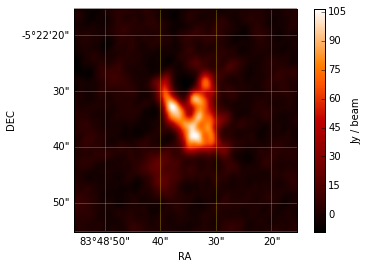

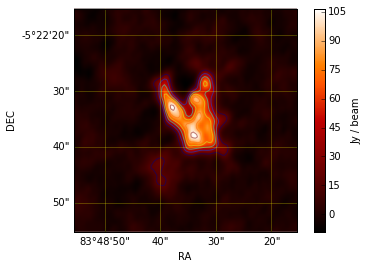

In [9]:
m0 = moment0(orion)
visualize(m0)
visualize(m0,contour=True)

### And the same for moments 1 and 2

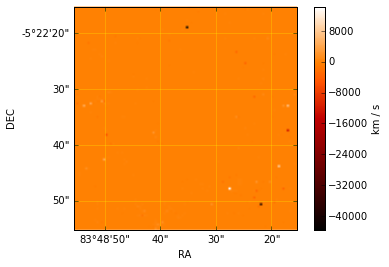

../acalib/core/utils.py:66: RuntimeWarning: invalid value encountered in sqrt
  m2=np.sqrt(beta*var/m0 - m1*m1)


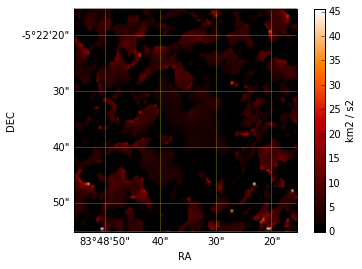

In [10]:
visualize(moment1(orion))
visualize(moment2(orion))

## After denoising

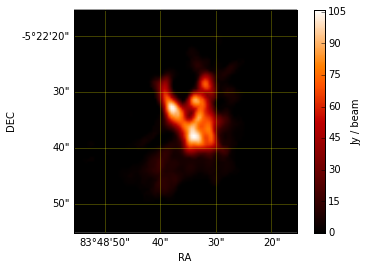

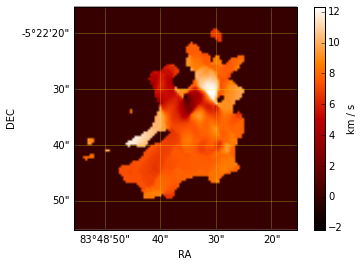

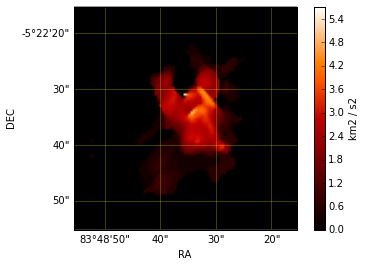

In [11]:
rms       = estimate_rms(orion)
den_orion = denoise(orion,threshold=1.5*rms)
visualize(moment0(den_orion))
visualize(moment1(den_orion))
visualize(moment2(den_orion))

# Data Manipulation

ACALib support images with masks, and still they can be manipulated.
Let us change the file to M100 galaxy

In [12]:
container = load_fits(m100_path)
M100      = container.primary
#visualize(M100)

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]


## Denoise and visualize 
With and without contours

../acalib/core/utils.py:115: RuntimeWarning: invalid value encountered in greater
  elms=data>threshold


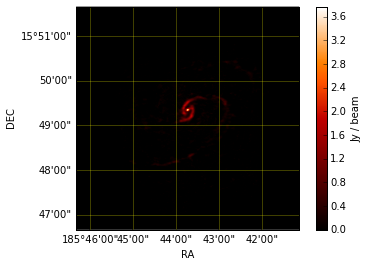

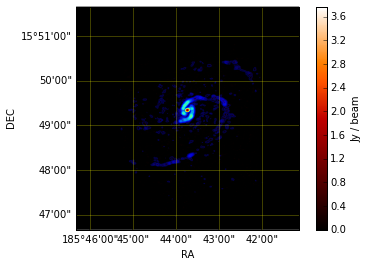

In [13]:
rms  = estimate_rms(M100)
M100 = denoise(M100,threshold=2.0*rms)
#visualize(M100,contour=True)
visualize(moment0(M100))
visualize(moment0(M100),contour=True)

## Change rest frequency

Rest Freq = 115.2712018 GHz


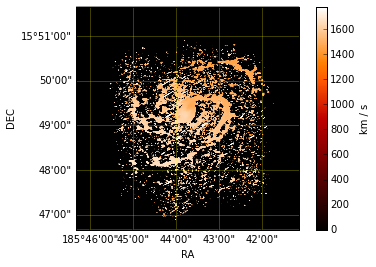

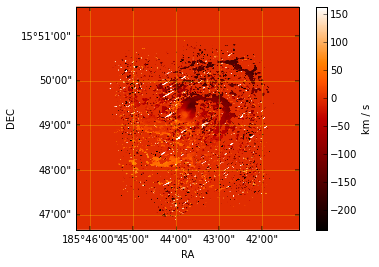

In [14]:
rfreq = M100.wcs.wcs.restfrq*u.Hz
print "Rest Freq =", rfreq.to(u.GHz)
visualize(moment1(M100))
visualize(moment1(M100,restfrq=114.65*u.GHz))

## Get an Spectrum

In [15]:
M100.wcs.celestial.printwcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 185.72874999999999  15.81944444444  
CRPIX : 301.0  301.0  
PC1_1 PC1_2 : 1.0  0.0  
PC2_1 PC2_2 : 0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  
NAXIS    : 600 600


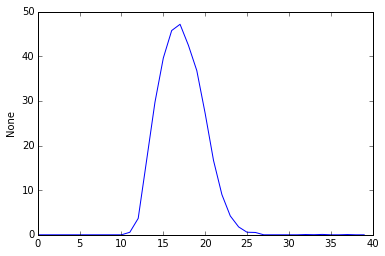

In [17]:
pos       = [301,301]*u.pix
ape       = 10*u.pix
m100_line = spectra(M100,position=pos,aperture=ape)
visualize(m100_line)

## Get a subcube

In [18]:
M100.wcs.printwcs()

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  
CRVAL : 185.72874999999999  15.81944444444  114587503125.0  
CRPIX : 301.0  301.0  1.0  
PC1_1 PC1_2 PC1_3 : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3 : 0.0  0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  3906250.0  
NAXIS    : 600 600


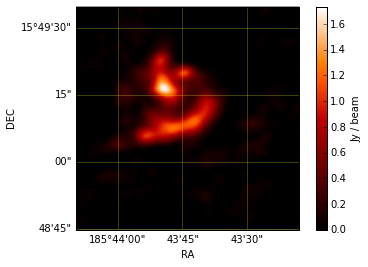

In [19]:
lb=[10,250,250]
ub=[20,350,350]
M100cut = cut(M100,lower=lb,upper=ub)
#visualize(M100)
visualize(moment0(M100cut))

# Synthetic Data
## Methanol Cloud

In [20]:
from acalib.synthetic import *

center   = [186.3,15.3]*u.deg
temp     = 300*u.K
rad_vel  = 150*u.km/u.s

univ=Universe()
univ.create_source('Methcloud',center)

# Defines a new component
mol_list = {'33SO2':[1.0,10.0]* u.Jy/u.beam}
offset   = [0,0]*u.arcsec
std      = [10,7]*u.arcsec
angle    = np.pi/9.*u.rad
fwhm     = 30*u.km/u.s
gradient = [0.0,0.0]*u.km/(u.s*u.arcsec)

# Create Component
model=GaussianIMC(mol_list,temp,offset,std,angle,fwhm,gradient)
model.set_velocity(rad_vel)
univ.add_component('Methcloud',model)


INFO: Source 'Methcloud' added
 [acalib.synthetic.vu]
INFO: Added component Methcloud::1 with model species = {'33SO2': <Quantity [  1., 10.] Jy / beam>} temp = 300.0 K offset = [ 0.  0.] deg std = [ 10.   7.] arcsec angle = 0.349065850399 rad fwhm = 30.0 km / s  gradient = [ 0.  0.] km / (arcsec s) [acalib.synthetic.vu]


In [21]:
# Create Cube
ang_res = [3.0,3.0]*u.arcsec
fov     = [200,200]*u.arcsec
freq    = 299.898*u.GHz
spe_res = 0.002*u.GHz
bw      = 0.2*u.GHz
noise   = 0.001*u.Jy/u.beam

cont = univ.gen_cube(center, ang_res, fov, freq, spe_res, bw, noise,noise/50.0)

INFO: Projecting source Methcloud [acalib.synthetic.vu]
INFO: Projecting Source at [ 186.3   15.3] deg [acalib.synthetic.vu]
INFO: Projecting Methcloud::1 [acalib.synthetic.vu]
SELECT * FROM Lines WHERE SPECIES like '33SO2' AND FREQ > 299649.034235 AND FREQ < 299848.934191
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.021797 MHz(299742.0095 MHz) intens=0.00226228069526 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.06842 MHz(299742.0561 MHz) because I=6.34813990594e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.346059 MHz(299742.3336 MHz) because I=6.34813990594e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.392782 MHz(299742.3803 MHz) intens=0.00217844444792 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299895.154664 MHz(299745.1408 MHz) because I=4.76482185954e-06 Jy / beam < 2e-05 Jy / beam [acalib

/Users/mauricio/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


## Visualize

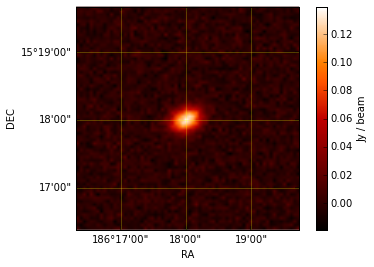

In [22]:
synthetic=cont.primary
visualize(moment0(synthetic))

In [23]:
# Defines a new component
mol_list = {'33SO2': [0.5,5.0]* u.Jy/u.beam}
offset   = [20,-20]*u.arcsec
std      = [4,12]*u.arcsec
angle    = np.pi/4.*u.rad
fwhm     = 10*u.km/u.s
gradient = [-3.0,3.0]*u.km/(u.s*u.arcsec)
# Create Component
model=GaussianIMC(mol_list,temp,offset,std,angle,fwhm,gradient)
model.set_velocity(rad_vel)
univ.add_component('Methcloud',model)

# Defines a new component
mol_list = {'33SO2':[0.5,8.0]* u.Jy/u.beam}
offset   = [-20,20]*u.arcsec
std      = [4,12]*u.arcsec
angle    = np.pi/6.*u.rad
fwhm     = 10*u.km/u.s
gradient = [3.0,-3.0]*u.km/(u.s*u.arcsec)

# Create Component
model=GaussianIMC(mol_list,temp,offset,std,angle,fwhm,gradient)
model.set_velocity(rad_vel)
univ.add_component('Methcloud',model)


INFO: Added component Methcloud::2 with model species = {'33SO2': <Quantity [ 0.5, 5. ] Jy / beam>} temp = 300.0 K offset = [ 0.00555556 -0.00555556] deg std = [  4.  12.] arcsec angle = 0.785398163397 rad fwhm = 10.0 km / s  gradient = [-3.  3.] km / (arcsec s) [acalib.synthetic.vu]
INFO: Added component Methcloud::3 with model species = {'33SO2': <Quantity [ 0.5, 8. ] Jy / beam>} temp = 300.0 K offset = [-0.00555556  0.00555556] deg std = [  4.  12.] arcsec angle = 0.523598775598 rad fwhm = 10.0 km / s  gradient = [ 3. -3.] km / (arcsec s) [acalib.synthetic.vu]


In [24]:
# Create Cube
ang_res = [3.0,3.0]*u.arcsec
fov     = [200,200]*u.arcsec
freq    = 299.898*u.GHz
spe_res = 0.002*u.GHz
bw      = 0.2*u.GHz
noise   = 0.001*u.Jy/u.beam

cont = univ.gen_cube(center, ang_res, fov, freq, spe_res, bw, noise,noise/50.0)

INFO: Projecting source Methcloud [acalib.synthetic.vu]
INFO: Projecting Source at [ 186.3   15.3] deg [acalib.synthetic.vu]
INFO: Projecting Methcloud::1 [acalib.synthetic.vu]
SELECT * FROM Lines WHERE SPECIES like '33SO2' AND FREQ > 299649.034235 AND FREQ < 299848.934191
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.021797 MHz(299742.0095 MHz) intens=0.0020830222613 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.06842 MHz(299742.0561 MHz) because I=5.84512645561e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.346059 MHz(299742.3336 MHz) because I=5.84512645561e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.392782 MHz(299742.3803 MHz) intens=0.00200582902445 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299895.154664 MHz(299745.1408 MHz) because I=4.38726724996e-06 Jy / beam < 2e-05 Jy / beam [acalib.

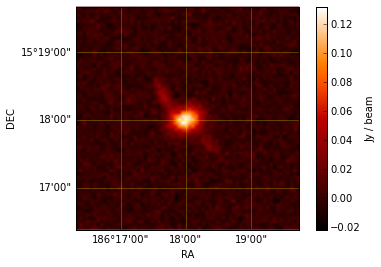

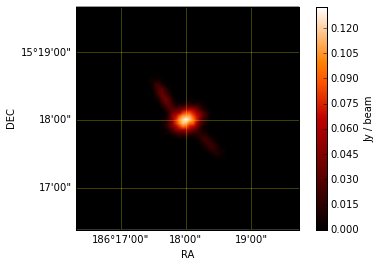

In [25]:
synthetic=cont.primary
visualize(moment0(synthetic))
syden=denoise(synthetic,threshold=2.0*estimate_rms(synthetic))
visualize(moment0(syden))

In [26]:
cont.table[0]

Source Name,Comp ID,Model,Alpha,Delta,Redshift,Radial Vel
string640,string640,string320,float64,float64,float64,float64
Methcloud,Methcloud::1,Gaussian IMC,186.3,15.3,0.000500471378582,150000.0
Methcloud,Methcloud::2,Gaussian IMC,186.294444444,15.3055555556,0.000500471378582,150000.0
Methcloud,Methcloud::3,Gaussian IMC,186.305555556,15.2944444444,0.000500471378582,150000.0


In [27]:
cont.table[1]

Line Code,Mol,Ch Name,Rest Freq,Obs Freq,Intensity
string640,string320,string320,float64,float64,float64
Methcloud::1-l1,33SO2,Sulfur Dioxide,299742.0095,299892.021797,0.0020830222613
Methcloud::1-l4,33SO2,Sulfur Dioxide,299742.3803,299892.392782,0.00200582902445
Methcloud::1-l9,33SO2,Sulfur Dioxide,299748.6847,299898.700337,0.00216667658616
Methcloud::1-l10,33SO2,Sulfur Dioxide,299749.0412,299899.057016,0.00193416753872


In [ ]:
cont.table[2]